In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch_mist.data.multimixture import MultivariateCorrelatedNormalMixture
from torch_mist.utils import train_mi_estimator
import pandas as pd

sns.set_style('whitegrid')
IMG_SIZE=3
n_dim = 5

train_parameters = dict(
    max_epochs=10,
    batch_size= 128,
    return_log=True,
    verbose=True,
    valid_percentage=0,
    lr_annealing=True,
)

# Definition of the distribution
p_XY = MultivariateCorrelatedNormalMixture(n_dim=n_dim)

true_mi = p_XY.mutual_information('x','y')

p_Y_given_X = p_XY.conditional('x')
p_Y = p_XY.marginal('y')

In [2]:
samples = p_XY.sample([100000])



In [3]:
from torch_mist.estimators import nwj, mine, doe, js, flo
from torch_mist.utils.logging import PandasLogger
from torch_mist.utils.logging.agg import compute_mean_std

estimators = {
    # 'DoE': doe(
    #     x_dim=n_dim,
    #     y_dim=n_dim,
    #     hidden_dims=[256, 128],
    #     conditional_transform_name='conditional_spline',
    #     marginal_transform_name='spline'
    # ),
    'MINE': mine(
        x_dim=n_dim,
        y_dim=n_dim,
        hidden_dims=[256, 128],
        neg_samples=1
    )
}


logger = PandasLogger()
for name, estimator in estimators.items():
    logger.log_method(estimator, method_name='log_ratio', agg=compute_mean_std)
    logger.log_method(estimator, method_name='batch_loss', agg=compute_mean_std)


In [4]:
log = train_mi_estimator(
    estimator=estimators['MINE'],
    x=samples['x'],
    y=samples['y'],
    batch_size=64,
    max_epochs=10,
    early_stopping=False,
    logger=logger,
    lr_annealing=False,
    optimizer_params={'lr':5e-4}
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1407 [00:00<?, ?it/s]

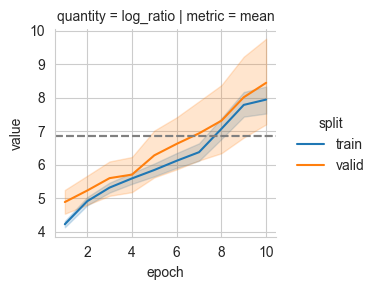

In [5]:
grid = sns.FacetGrid(log, col='metric', hue='split', row='quantity', row_order=['log_ratio'], col_order=['mean'])
grid.map(sns.lineplot, 'epoch', 'value')
grid.add_legend()
grid.refline(y=true_mi)


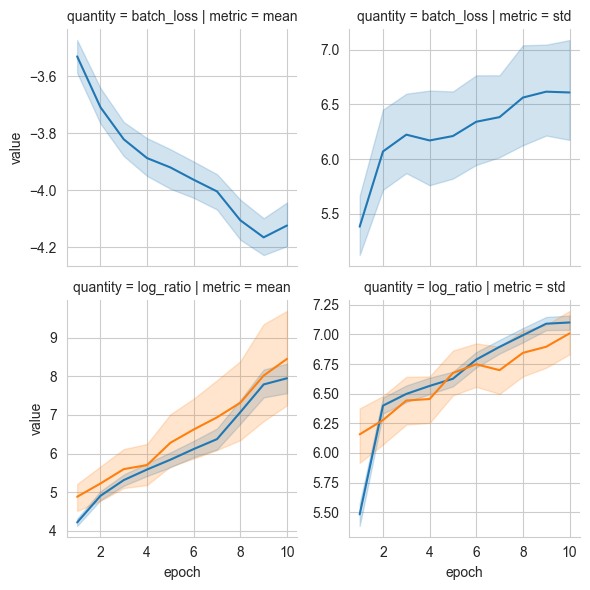

In [6]:
grid = sns.FacetGrid(log, row='quantity', col='metric', hue='split', sharey=False, sharex=True)
grid.map(sns.lineplot, 'epoch', 'value')
# plt.ylim(0,20)

In [7]:
estimators = {
    'DoE': doe(
        x_dim=n_dim,
        y_dim=n_dim,
        hidden_dims=[256, 128],
        conditional_transform_name='conditional_linear',
        marginal_transform_name='spline',
    ),
}


logger = PandasLogger()
for name, estimator in estimators.items():
    logger.log_method(estimator, method_name='log_ratio', agg=compute_mean_std)
    logger.log_method(estimator, method_name='batch_loss', agg=compute_mean_std)

In [8]:
log = train_mi_estimator(
    estimator=estimators['DoE'],
    x=samples['x'],
    y=samples['y'],
    batch_size=64,
    max_epochs=10,
    early_stopping=False,
    logger=logger,
    lr_annealing=False,
    optimizer_params={'lr':5e-4}
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1407 [00:00<?, ?it/s]

(0.0, 8.0)

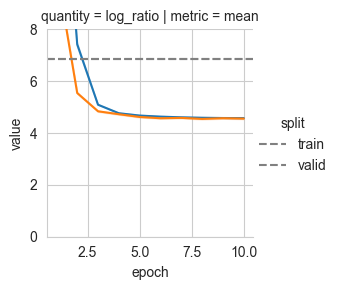

In [9]:
grid = sns.FacetGrid(log, col='metric', hue='split', row='quantity', row_order=['log_ratio'], col_order=['mean'])
grid.map(sns.lineplot, 'epoch', 'value')
grid.refline(y=true_mi)
grid.add_legend()
plt.ylim(0,8)

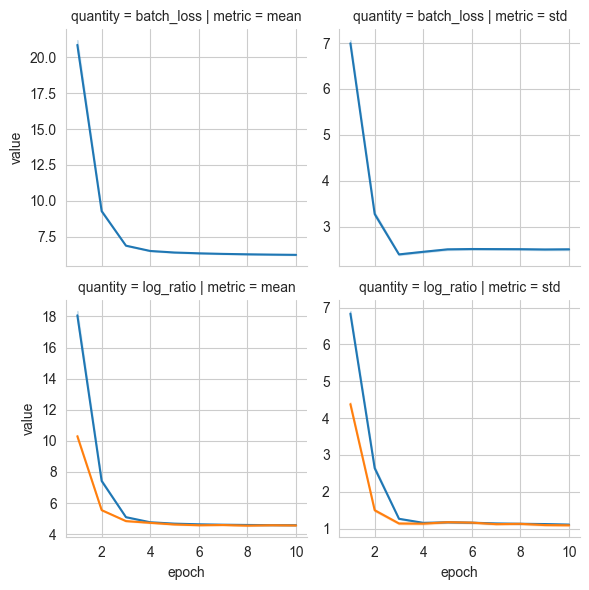

In [10]:
grid = sns.FacetGrid(log, row='quantity', col='metric', hue='split', sharey=False, sharex=True)
grid.map(sns.lineplot, 'epoch', 'value')
# plt.ylim(0,20)

In [28]:
from torch_mist.utils.freeze import freeze
from torch_mist.estimators.hybrid.base import HybridMIEstimator

estimator = HybridMIEstimator(
    generative_estimator=freeze(estimators['DoE']),
    discriminative_estimator=mine(
        x_dim=n_dim,
        y_dim=n_dim,
        hidden_dims=[128, 128],
        neg_samples=1
    )
)

logger = PandasLogger()
logger.log_method(estimator, method_name='batch_loss', agg=compute_mean_std)
logger.log_method(estimator, method_name='log_ratio', agg=compute_mean_std)

In [29]:
log = train_mi_estimator(
    estimator=estimator,
    x=samples['x'],
    y=samples['y'],
    batch_size=64,
    max_epochs=10,
    early_stopping=False,
    logger=logger,
    lr_annealing=False,
    optimizer_params={'lr':5e-4}
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1407 [00:00<?, ?it/s]

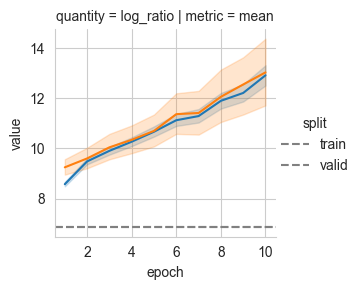

In [30]:
grid = sns.FacetGrid(log, col='metric', hue='split', row='quantity', row_order=['log_ratio'], col_order=['mean'])
grid.map(sns.lineplot, 'epoch', 'value')
grid.refline(y=true_mi)
grid.add_legend()
# plt.ylim(0,8)

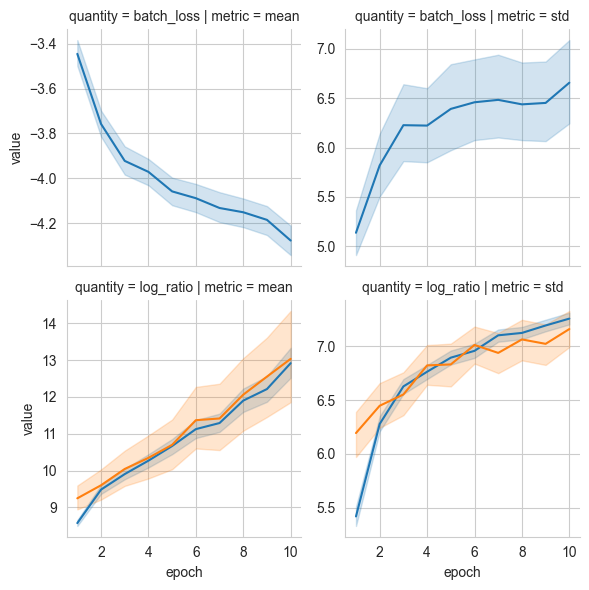

In [31]:
grid = sns.FacetGrid(log, row='quantity', col='metric', hue='split', sharey=False, sharex=True)
grid.map(sns.lineplot, 'epoch', 'value')
# plt.ylim(0,20)

In [51]:
logger._logged_methods

{'batch_loss', 'log_ratio'}

In [23]:
logger.reset()
with logger.test():
    estimator.batch_loss(torch.zeros(1,n_dim), torch.zeros(1,n_dim))

In [24]:
logger.get_log()

,metric,value,quantity,iteration,epoch,split
0,mean,1.303852e-08,batch_loss,0,0,test
1,std,NaN,batch_loss,0,0,test


In [27]:
estimator.discriminative_estimator.proposal.transforms

[ConditionedLinear()]